In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.datasets import  make_classification
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython import display

import copy
import random
import time

Это игрушечно -исследовательское задание
Перед Вами задача бинарной классификации. Как модель мы будем использывать двуслойный перцептрон.
Изучите, как отрабатывают различные оптимизаторы на этой задаче. Обязательно попробовать  Adam, RMSProp, SGD, L-BFGS. Другие тоже можно

Сделать выводы по полученным результатам.

In [5]:
#  Делаем рандомную задачу бинарной классификации. По умолчанию make_classification порождает объект с 20 признаками. 
# Это значение можно варьировать. И его надо подавать как input_size в моддель
X, Y = make_classification(n_samples=200)

# Делим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.2, random_state=42)

# перегоняем все в торч
x_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)

x_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

In [6]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([160, 20]),
 torch.Size([40, 20]),
 torch.Size([160]),
 torch.Size([40]))

In [7]:
# Cтроим простой перцептрончик: Один линейный слой потом Релу (что это такое, кстати?=)), еще линейный слой и сигмоиду, которая будет выдавать вероятности классов
# hidden size можно варьировать. input_size - кол-во признаков в объекте

class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size

        self.linear1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        hidden = self.linear1(x)
        relu = self.relu(hidden)
        output = self.linear2(relu)
        output = self.sigmoid(output)
        return output

In [20]:
def train_model(optimizer_cs, title, params, n_epochs=100):
    # модель
    model = MLP(20, 10)

    # Критерий/ функция потерь
    criterion = torch.nn.BCELoss()

     # Оптимизаторы. Можете потыкать все из торча. обязательно Adam, RMSProp, SGD, L-BFGS
    optimizer = optimizer_cs(model.parameters(), **params)

    sns.set(font_scale=1.3, style='darkgrid') 

    # размер батча. Тоже меняйте если хотите
    batch_size = 8 

    epoch_array = []
    epoch_test_array = []
    for epoch in range(n_epochs):

        # Тут игрушечный пример как делить на батчи
        permutation = torch.randperm(x_train.size()[0])
        loss_array = []

        model.train()
        for i in range(0,x_train.size()[0], batch_size):
            if title == 'L-BFGS':

                def loss_closure():
                    optimizer.zero_grad()
                    indices = permutation[i:i+batch_size]
                    batch_x, batch_y = x_train[indices], y_train[indices]
                    outputs = model.forward(batch_x)
                    loss = criterion(outputs.squeeze(), batch_y)
                    loss.backward()
                    return loss

                optimizer.step(loss_closure)
                loss_array.append(loss_closure().item())
            else:
                #  your code here 
                optimizer.zero_grad()

                # Бьем на батчи. В таком мигрушечном примере это не обязательно,
                # но мы будем делать все по феншую
                indices = permutation[i:i+batch_size]
                batch_x, batch_y = x_train[indices], y_train[indices]

                # Считаем лосс и добавляем его значение в массив
                outputs = model.forward(batch_x)
                loss = criterion(outputs.squeeze(), batch_y)
                
                loss_array.append(loss.item())
                loss.backward()
                optimizer.step()


        # Будем проверять как отрабатывает модель на тестовом датасете (ЗАЧЕМ?)
        # ТАк еж разбиваем на батчи, считаем лосс, но веса модели не обновляем
        test_permutation = torch.randperm(x_test.size()[0])
        loss_test_array = []
        model.eval()
        for i in range(0,x_test.size()[0], batch_size):

            indices = test_permutation[i:i+batch_size]
            batch_x, batch_y = x_test[indices], y_test[indices]
            outputs = model.forward(batch_x)
            loss = criterion(outputs.squeeze(), batch_y)
            loss_test_array.append(loss.item())

        # усредняем лосс на обучении и тесте по эпохе  и выводим график
        epoch_array.append(np.mean(loss_array))
        epoch_test_array.append(np.mean(loss_test_array))

        display.clear_output(wait=True)
        plt.figure(figsize =(12, 7))
        plt.plot(epoch_array, label='train')
        plt.plot(epoch_test_array, label='test')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(title)
        plt.legend()
        plt.show()

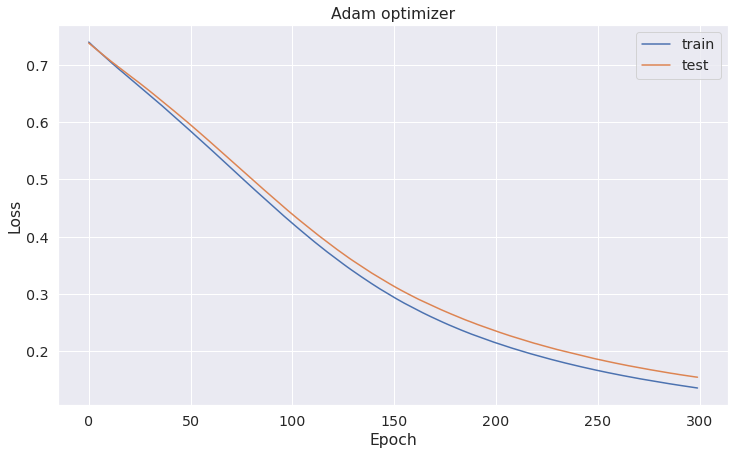

In [ ]:
train_model(torch.optim.Adam, 'Adam optimizer', {'lr': 1e-4}, n_epochs=300)

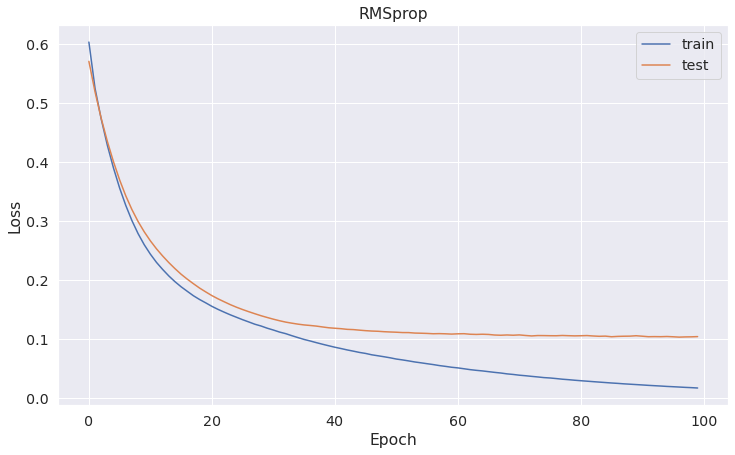

In [ ]:
train_model(torch.optim.RMSprop, 'RMSprop', {'lr': 1e-3}, n_epochs=100)

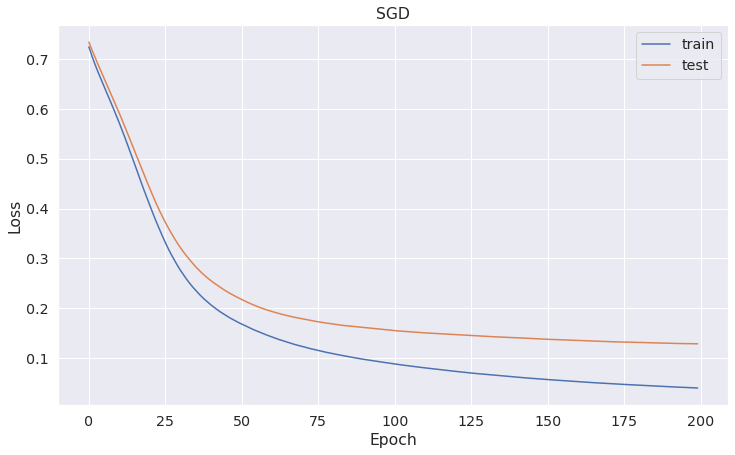

In [ ]:
train_model(torch.optim.SGD, 'SGD', {'lr': 1e-2}, n_epochs=200)

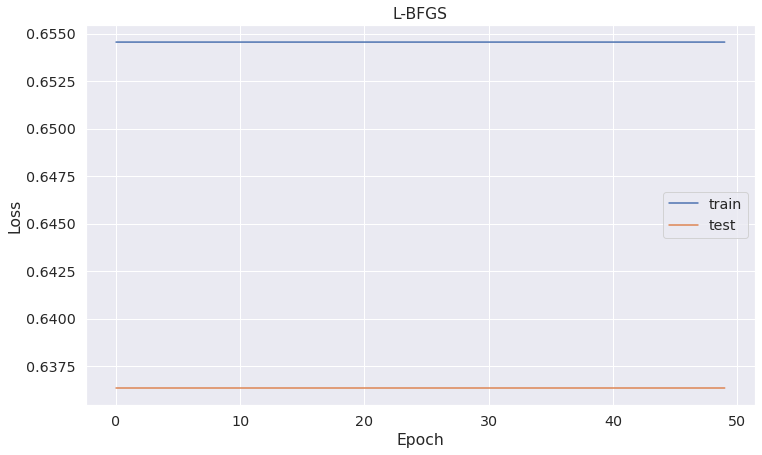

In [31]:
train_model(torch.optim.LBFGS, 'L-BFGS', {'lr': 1e-2, 'history_size': 3, 'max_iter': 2}, n_epochs=50)

ОПИШИТЕ ПОЛУЧЕНННЫЕ РЕЗУЛЬТАТЫ

Нам удалось добиться неплохой точности при помощи различных оптимизаторов. `RMSProp` сошёлся достаточно быстро и потом ошибка на тестовой выборке оставалась на месте, однако на тренировочной продолжала падать.

`Adam` сходился медленнее, так как пришлось поставить небольшой шаг обучения. Иначе бы он не сходился.

`SGD` также хорошо сходится. В этом методе можно поставить шаг обучения побольше.

`L-BFGS` творит какие-то странные вещи.